### Campaign ROI Model

- Assumption: phone calls to leads are independent with respect to one another so we do not treat this as a time series problem

- Objective: create ML model to select target customers within customer segment as part of given campaign
- Customers are selected within the segment based on avg customer clv
- A higher avg customer clv will allow for a proportionally lower decision threshold, and viceversa
- Duration cannot be used

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')
warnings.filterwarnings('ignore', 'Data with input dtype int64*')
warnings.filterwarnings('ignore', 'The default value*')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer, LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_pickle('data/data_ready.pickle')

In [7]:
df.drop('duration', axis=1, inplace=True)

In [8]:
#One more check: no nulls so no need to use imputers in pipeline
#df.isnull().sum()

In [9]:
#not just of type numeric, but actual numeric on a scale - excludes binary and ordinal categorical attributes
#the below attributes will be scaled in the Pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                   'cons.conf.idx', 'euribor3m', 'nr.employed', 'month_total_days']

In [10]:
binary_features = ['biz_payday', 'govt_payday', 'is_holiday']

In [11]:
#outcome is y,n,unknown
categorical_features = ['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'month_last_contact', 'day_of_week_last_contact', 'holiday_name', 'weekday']

In [12]:
label_binary = ['contact']

In [13]:
#passthrough = ['year', 'month', 'day']

In [27]:
models = {}
models['log'] = (LogisticRegression(solver='lbfgs'), {'C':[0.01, 0.1, 1], 'class_weight':['balanced']})
models['ridge'] = (RidgeClassifier(), {'alpha':[0.01, 0.1, 1]})

In [28]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [29]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binary_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', Binarizer())])

label_binary_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_binary', OneHotEncoder(sparse=False))])

#intact_transformer = Pipeline(steps=[
#    ('intact', )
#])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', binary_transformer, binary_features), 
    ('lab_bin', label_binary_transformer, label_binary) 
], 
    #setting remainder to passthrough so features that are not included are not dropped
    remainder='passthrough')

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', models['log'][0])])

In [30]:
#NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

classifier, param_grid = models['log'][0], models['log'][1]

new_param_grid = {}
for i,k in param_grid.items():
    j = 'clf__'+i
    new_param_grid[j] = k

#Using stratified kfold to address imbalanced classes in target feature:
cv = StratifiedKFold(n_splits=5, random_state=1)

In [35]:
gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring='accuracy')

gs.fit(X_train, y_train)

cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

print("\n---------")
print("Model Evaluated: ", gs.best_estimator_.named_steps['clf'])
print("Training {} Mean with CV: {}".format('accuracy', cv_metric.mean()))
print("Training {} Standard Dev with CV: {}".format('accuracy', cv_metric.std()))
print("Test Score: %.3f" % gs.score(X_test, y_test))


---------
Model Evaluated:  LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.8062508740417194
Training accuracy Standard Dev with CV: 0.006517146492149174
Test Score: 0.811


In [32]:
model_results = {}

In [40]:
for k, (model, params) in models.items():
    print(k,'\n\n', model, '\n\n', params)

log 

 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 

 {'C': [0.01, 0.1, 1], 'class_weight': ['balanced']}
ridge 

 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001) 

 {'alpha': [0.01, 0.1, 1]}


In [111]:
#Models to be evaluated - can be modified/overridden to include more
def models():
    models = {}
    models['log'] = (LogisticRegression(solver='lbfgs'), {'C':[0.01, 0.1, 1]})
    models['ridge'] = (RidgeClassifier(), {'alpha':[0.01, 0.1, 1]})
    models['svc'] = (SVC(), {'C':[0.1, 1], 'gamma':['auto']})
    models['gaus_nb'] = (GaussianNB(), {'var_smoothing':[1e-9, 1]})
    models['bagging_class'] = (BaggingClassifier(), {'n_estimators':[7,12], 'max_samples':[1,5]})
    models['rf_class'] = (RandomForestClassifier(), {'max_depth':[100, 1000], 'max_leaf_nodes':[10, 20, 30]})
    
    return models

In [112]:
#Split data between training and test sets
def split_data(df, target_name, test_size):

    X = df.drop(str(target_name), axis=1)
    y = df[str(target_name)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [113]:
def processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('label_binary', OneHotEncoder(sparse=False))])
    
    #intact_transformer = Pipeline(steps=[
    #    ('intact', )
    #])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, bin_features), 
        ('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', classifier)])

    return pipe

In [114]:
#Evaluate classifiers:
def evaluate_classifier(X_train, X_test, y_train, y_test, pipe, classifier_paramgrid, metric):

    #NB: classifier_paramgrid should be a tuple with the classifier and its associated param grid for GridsearchCV

    classifier, param_grid = classifier_paramgrid[0], classifier_paramgrid[1]

    new_param_grid = {}
    for i,k in param_grid.items():
        j = 'clf__'+i
        new_param_grid[j] = k

    #Using stratified kfold to address imbalanced classes in target feature:
    cv = StratifiedKFold(n_splits=5, random_state=1)
    
    #Customization for timeseries: using TimeSeriesSplit
    #cv = TimeSeriesSplit(n_splits=2)

    gs = GridSearchCV(estimator=pipe, param_grid=[new_param_grid], n_jobs=-1, cv=cv, scoring=metric)

    gs.fit(X_train, y_train)

    cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", classifier_paramgrid[0])
    print("Training {} Mean with CV: {}".format(metric, cv_metric.mean()))
    print("Training {} Standard Dev with CV: {}".format(metric, cv_metric.std()))
    print("Test Score: %.3f" % gs.score(X_test, y_test))

    return cv_metric

In [115]:
#Main function to execute the workflow
def execute_spotcheck(df, target_name, test_size, numeric_features, categorical_features, bin_features, lab_bin_features):

    #Split the data so to leave a final test set to avoid data leakage
    X_train, X_test, y_train, y_test = split_data(df, target_name, test_size)

    #Create a dictionary holding models that will be evaluated
    models_tested = models()

    model_results = {}

    for k, (model, params) in models_tested.items():
        #Create pipeline to apply the same transformations to each model evaluated
        pipe = processing_pipeline(numeric_features, categorical_features, bin_features, lab_bin_features, model)
        cv_metric = evaluate_classifier(X_train, X_test, y_train, y_test, pipe, (model, params), 'accuracy')
        model_results[k] = cv_metric

    return model_results, models_tested

In [116]:
#Simple visualization of outcomes:
def visualize_results(model_results, models_tested):
    
    models_report = pd.DataFrame(model_results, columns=list(models_tested.keys()))
    
    fig, ax1 = plt.subplots(figsize=(len(models_report.columns)*3,4))
    sns.boxplot(data=models_report, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

In [132]:
model_results, models_tested = execute_spotcheck(df, 'y', 0.3, numeric_features, categorical_features, binary_features, label_binary)


---------
Model Evaluated:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Training accuracy Mean with CV: 0.901321366242076
Training accuracy Standard Dev with CV: 0.0011136027244710417
Test Score: 0.898

---------
Model Evaluated:  RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Training accuracy Mean with CV: 0.9008359053322632
Training accuracy Standard Dev with CV: 0.0008522984801025358
Test Score: 0.898

---------
Model Evaluated:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2


---------
Model Evaluated:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training accuracy Mean with CV: 0.900662432773719
Training accuracy Standard Dev with CV: 0.0009254138183673803
Test Score: 0.897


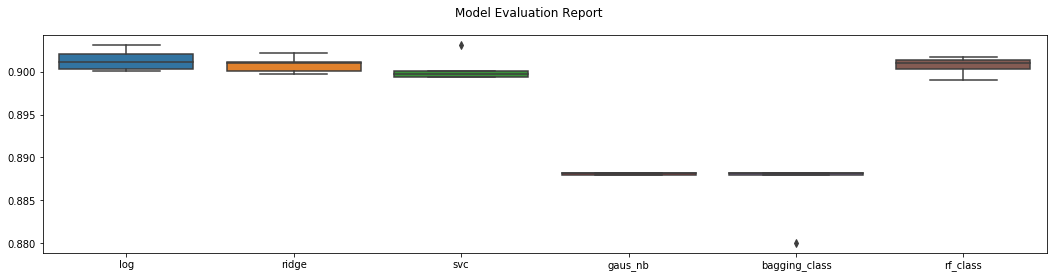

In [133]:
visualize_results(model_results, models_tested)

In [136]:
models_tested.items()

dict_items([('log', (LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False), {'C': [0.01, 0.1, 1]})), ('ridge', (RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001), {'alpha': [0.01, 0.1, 1]})), ('svc', (SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False), {'C': [0.1, 1], 'gamma': ['auto']})), ('gaus_nb', (GaussianNB(priors=None, var_smoothing=1e-09), {'var_smoothing': [1e-09, 1]})), ('bagging_class', (BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_featur

Tune According to Campaign ROI as defined by differenced between avg loan and deposit interest rates and fixed/var campaign costs

In [42]:
clf = LogisticRegression(C=1, max_iter=100, class_weight = 'balanced')

In [43]:
clf.fit(X,y)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [44]:
y_pred = clf.predict(X)

In [45]:
def make_conf_matrix(clf, X,y):
    y_pred = clf.predict(X)
    cmx = pd.DataFrame(confusion_matrix(y, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [46]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

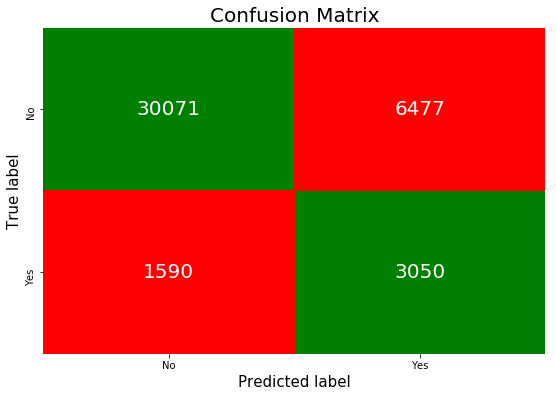

In [47]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(clf, X, y)
plot_conf_matrix(cmx)

In [48]:
print("Campaign Targets:", cmx.iloc[1,1]+cmx.iloc[0,1])

Campaign Targets: 9527


In [49]:
accept_est = cmx.iloc[1,1]
reject_est = cmx.iloc[0,1]
total_targeted = accept_est+reject_est

In [50]:
type(y)

pandas.core.series.Series

In [51]:
#enhancement: create rolling window logistic regression predicting next month's subscriptions

In [52]:
Xex = X[['year','month','age','job','marital']]

In [53]:
Xex.head()

,year,month,age,job,marital
Date,,,,,
2008-05-05,2008,5,56,3,1
2008-05-05,2008,5,57,7,1
2008-05-05,2008,5,37,7,1
2008-05-05,2008,5,40,0,1
2008-05-05,2008,5,56,7,1


In [54]:
Xex.reset_index(drop=0, inplace=True)

In [56]:
y = y.reset_index(drop=1)

In [58]:
clf = LogisticRegression(solver='sag')

In [62]:
Xex.drop(columns='Date',inplace=True)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [63]:
clf.fit(Xex,y)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
clf.predict(np.array([1,2,3,1,1]).reshape(1,-1))

array([1], dtype=int8)

In [12]:
#for each value in decision threshold range, 
    #create logistic regression
    #calculate profit for campaign with average CLV for next x months
#select the logistic regression yielding the highest ROI

Campaign ROI Calculation

In [44]:
%store -r 'pred_clv'

In [49]:
customers_monthly = df[['year','month','day']].groupby(by=['year','month']).count()
customers_monthly = customers_monthly.reset_index()
customers_monthly.rename(columns = {'day':'count'},inplace=True)
customers_monthly.head()

,year,month,count
0,2008,5,7763
1,2008,6,4374
2,2008,7,6685
3,2008,8,5175
4,2008,10,67


In [50]:
customers_monthly['perc_of_total'] = customers_monthly['count']/customers_monthly['count'].sum()

In [20]:
def calc_revenue(accept_est, pred_clv):
    return accept_est*pred_clv     

In [ ]:
#calculate revenue on a monthly basis comparing with predicted customer clv
#compare y with y pred and do a monthly classification matrix

In [53]:
revenue_est = calc_revenue(customers_monthly['count'], pred_clv)

ValueError: Length of passed values is 32, index implies 26

In [23]:
revenue_est

array([[446637.00753979],
       [501670.21111085],
       [601489.25756288],
       [581586.91486844],
       [618839.30795804],
       [657785.29383017],
       [668546.34464979],
       [602267.51151426],
       [433297.83443806],
       [522265.27937144],
       [562186.62036074],
       [390829.6445475 ],
       [468068.19524095]])

In [ ]:
def calc_